# Launch processing

Confirm working location
*(this should be ./sample/FR-Gri_20220514)*

In [ ]:
import os
os.getcwd()


Saving
*-using python module*

In [ ]:
import waveletec
c = waveletec.handler.handle_eddypro_setup(eddypro="input/EP/FR-Gri_sample.eddypro")
c.update({'covariance': ["w*co2|w|co2|h2o", "w*co2|w*h2o", "w*h2o",],
          'outputpath': "test/wavelet_flux_DB6_55125_2/",
          'processduration': '6H'})
waveletec.handler.eddypro_wavelet_run(**c)
waveletec.handler.integrate_full_spectra_into_file(**c)
waveletec.handler.condition_sampling_partition(**c)

On demand
*-using python module*
*-no saving*

In [ ]:
import waveletec
c = waveletec.handler.handle_eddypro_setup(eddypro="input/EP/FR-Gri_sample.eddypro")
c.update({'covariance': ["w*co2|w|co2|h2o", "w*co2|w*h2o", "w*h2o",],
          'outputpath': None,  # important for it not to save somewhere
          'processduration': '6H',
          'datetimerange': '202205141200-202205141600'})
data_wl = waveletec.handler.eddypro_wavelet_run(**c)
data_fx = waveletec._core.wavelet_functions.integrate_cospectra(data_wl, 1/(60*30), None)
data_pt = waveletec._core.partition.partition_DWCS_H2O(
    data_fx, NEE='NEE', GPP='GPP', Reco='Reco', CO2='wco2', 
    CO2neg_H2Opos='wco2-wh2o+', CO2neg_H2Oneg='wco2-wh2o-', NIGHT=None).filter(['TIMESTAMP', 'NEE', 'GPP', 'Reco'])


From *.git* repository
*-command line*

In [ ]:
import subprocess

c = f'-ep "input/EP/FR-Gri_sample.eddypro"'
c += f' -v u v w co2 h2o'
#c += f' -d 202205130000-202205140000'
#c += f' -ip 3600'
c += f' -cov "co2*co2|co2" "w*co2|w*h2o" "w*h2o"'

# dwt: db16, coif4, haar, ...
# cwt: morlet, mexicanhat, ...
w = ('dwt', 'db6')

c += f' -o "output/wavelet_flux_{w[1].upper()}/"'
c += f' --processduration ' + '1D' if w[0] == 'dwt' else '3H'
c += f' --method {w[0]}'  # options: cov, dwt, cwt
c += f' --wave_mother {w[1]}'  # depends on method, if cov: ignored; if dwt: db2, db6, ..., coif4, ...; if cwt: morlet, mexicanhat, ...

subprocess.Popen(f'start "waveletec" cmd /k python ../../wavelet_handler.py {c}', shell=True)


# Demonstration

In [2]:
import os
if 'current_file_folder' not in globals(): current_file_folder = os.getcwd()
os.chdir(current_file_folder+'/../..')
from functools import reduce
import pandas as pd
import numpy as np
from waveletec._core import wavelet_functions

def get_rawdata(path):
    data = pd.read_csv(path, skiprows=9, sep='\s+', engine='python', na_values=[-9999, 'NAN'])
    data['TIMESTAMP'] = path.split('/')[-1].split('_')[0].split('.')[0]
    data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'], format='%Y%m%d-%H%M')
    return data

corrraw_data = (reduce(lambda left, right: pd.concat([left, right]),
                      [get_rawdata(f'{current_file_folder}/output/eddypro_raw_datasets/level_6/{f}') 
                       for f in os.listdir(f'{current_file_folder}/output/eddypro_raw_datasets/level_6/')[10:60]]))
corrraw_data['TIMESTAMP_ns'] = corrraw_data['TIMESTAMP'] + corrraw_data.index * pd.to_timedelta('0.05s')
corrraw_data = corrraw_data.reset_index(drop=True)
for v in ['w', 'ts', 'co2', 'h2o']:
    corrraw_data[v+'_'] = corrraw_data.groupby('TIMESTAMP')[v].transform(np.nanmean)


Attenuation

Text(0, 0.5, 'value')

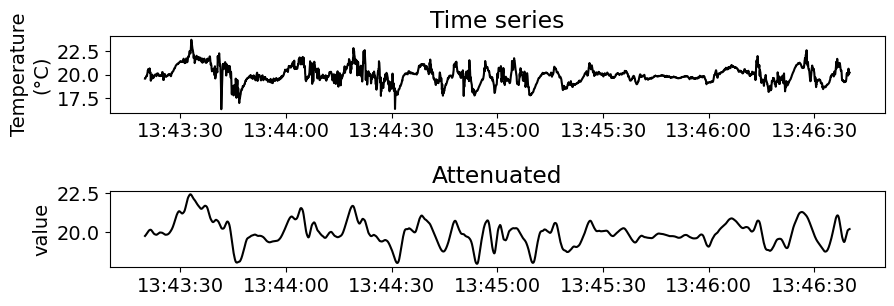

In [2]:
from matplotlib import pyplot as plt 

plt.rcParams.update({'font.size': 14})
subp = plt.subplots(3,1, figsize=(10, 3), gridspec_kw={'height_ratios': [3,2,3]})
jmin = 5
jmax = None

thisraw_data = corrraw_data.interpolate().dropna(axis=1, how='all').dropna().copy()
wl_t_signal, j = wavelet_functions.universal_wt((thisraw_data['ts']-272.15).to_list(), 'dwt', wavelet='db6', fs=20, f0=1/(.5*60*60), f1=10, fn=180, 
                 dj=1/12, inv=True)

thisdate = "2022-05-13 13:30:00"
thisdate = pd.to_datetime(thisdate)
thisraw_data = thisraw_data.query(f'TIMESTAMP == "{thisdate}"')
thisraw_data = thisraw_data[16000 : 20000]

for i, ax in enumerate(subp[1]):
    if i==0: 
        #ax.plot(thisraw_data.TIMESTAMP_ns, thisraw_data['co2'], label='observed', c='0')
        ax.plot(thisraw_data.TIMESTAMP_ns, np.nansum(wl_t_signal[:, thisraw_data.index], 0), label='decomposed', c='0')
        ax.set_title('Time series')
        ax.set_ylabel('Temperature\n(°C)')
    elif i == 1: ax.axis('off')
    else: 
        ax.set_title('Attenuated')
        ax.plot(thisraw_data.TIMESTAMP_ns, np.nansum(wl_t_signal[jmin:jmax, thisraw_data.index], 0), label='decomposed', c='0')
plt.ylabel('value')

Decomposition

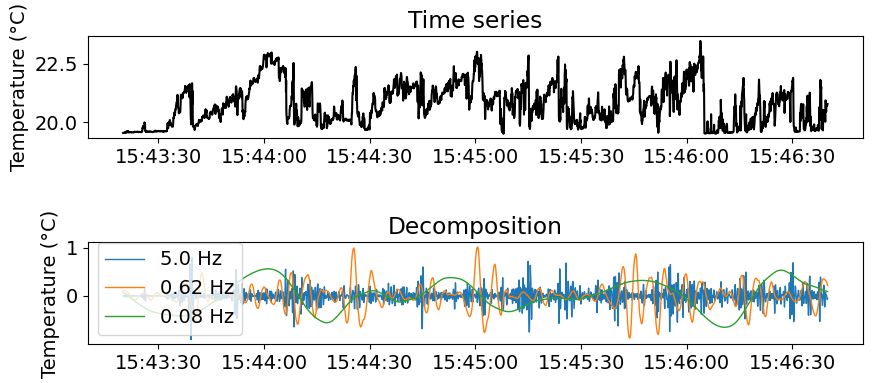

In [3]:
imax = 10
if imax > len(j): imax = len(j)
subp = plt.subplots(3, 1, figsize=(10,4), gridspec_kw={'height_ratios': [3,2,3]})
thisraw_data = corrraw_data.interpolate().dropna(axis=1, how='all').dropna().copy()
wl_t_signal, j = wavelet_functions.universal_wt((thisraw_data['ts']-272.15).to_list(), 'dwt', wavelet='db6', fs=20, f0=1/(.5*60*60), f1=10, fn=180, 
                 dj=1/12, inv=True)

thisdate = "2022-05-13 15:30:00"
thisdate = pd.to_datetime(thisdate)
thisraw_data = thisraw_data.query(f'TIMESTAMP == "{thisdate}"')
thisraw_data = thisraw_data[16000 : 20000]

for i, ax in enumerate(subp[1]):
    if i > imax+2: 
        ax.axis('off')
        continue
    if i==0: 
        ax.plot(thisraw_data.TIMESTAMP_ns, thisraw_data['ts']-272.15, label='observed', c='0')
        ax.set_title('Time series')
        ax.set_ylabel('Temperature (°C)')
    elif (i == 1) or (i+2 == len(subp[1])) or (i-1 == imax): ax.axis('off')
    else:
        if i == 2: ax.set_title('Decomposition')
        ax.set_ylabel('Temperature (°C)')
        for s in range(2, 10, len(wl_t_signal)//5):
            ax.plot(thisraw_data.TIMESTAMP_ns, wl_t_signal[s, thisraw_data.index], lw=1, label=str(round(20*2**-s, 2))+' Hz')
        #ax.plot(thisraw_data[0:2**i].TIMESTAMP_ns, wl_t_signal[i-2, thisraw_data.index][0:2**i], c='0')
plt.legend()


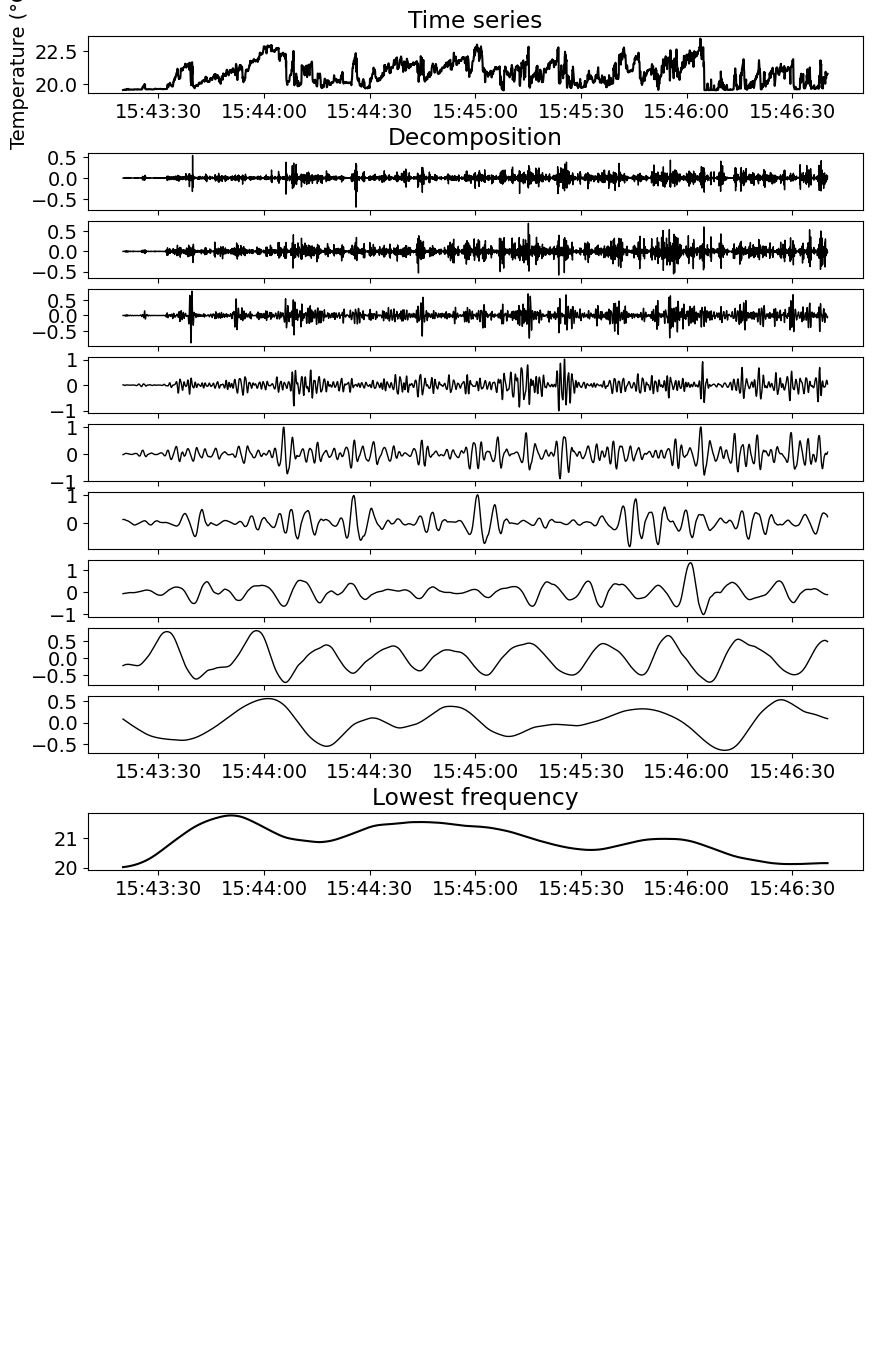

In [4]:
imax = 10
if imax > len(j): imax = len(j)
h_ratio = [3,2] + [3]*(len(j)+1)
h_ratio[imax+1] = 2
subp = plt.subplots(len(j)+3,1, figsize=(10,17), gridspec_kw={'height_ratios': h_ratio})

thisraw_data = corrraw_data.interpolate().dropna(axis=1, how='all').dropna().copy()
wl_t_signal, j = wavelet_functions.universal_wt((thisraw_data['ts']-272.15).to_list(), 'dwt', wavelet='db6', fs=20, f0=1/(.5*60*60), f1=10, fn=180, 
                 dj=1/12, inv=True)

thisdate = "2022-05-13 15:30:00"
thisdate = pd.to_datetime(thisdate)
thisraw_data = thisraw_data.query(f'TIMESTAMP == "{thisdate}"')
thisraw_data = thisraw_data[16000 : 20000]

for i, ax in enumerate(subp[1]):
    if i > imax+2: 
        ax.axis('off')
        continue
    if i==0: 
        ax.plot(thisraw_data.TIMESTAMP_ns, thisraw_data['ts']-272.15, label='observed', c='0')
        ax.set_title('Time series')
        ax.set_ylabel('Temperature (°C)')
    elif (i == 1) or (i+2 == len(subp[1])) or (i-1 == imax): ax.axis('off')
    elif (i == imax+2):
        ax.set_title('Lowest frequency')
        ax.plot(thisraw_data.TIMESTAMP_ns, np.nansum(wl_t_signal[i-3:, thisraw_data.index], 0), label='decomposed', c='0')
    else:
        if i == 2: ax.set_title('Decomposition')
        ax.plot(thisraw_data.TIMESTAMP_ns, wl_t_signal[i-2, thisraw_data.index], label='decomposed', lw=1, c='0')
        #ax.plot(thisraw_data[0:2**i].TIMESTAMP_ns, wl_t_signal[i-2, thisraw_data.index][0:2**i], c='0')


20Hz to 30min *(in time-scale)*

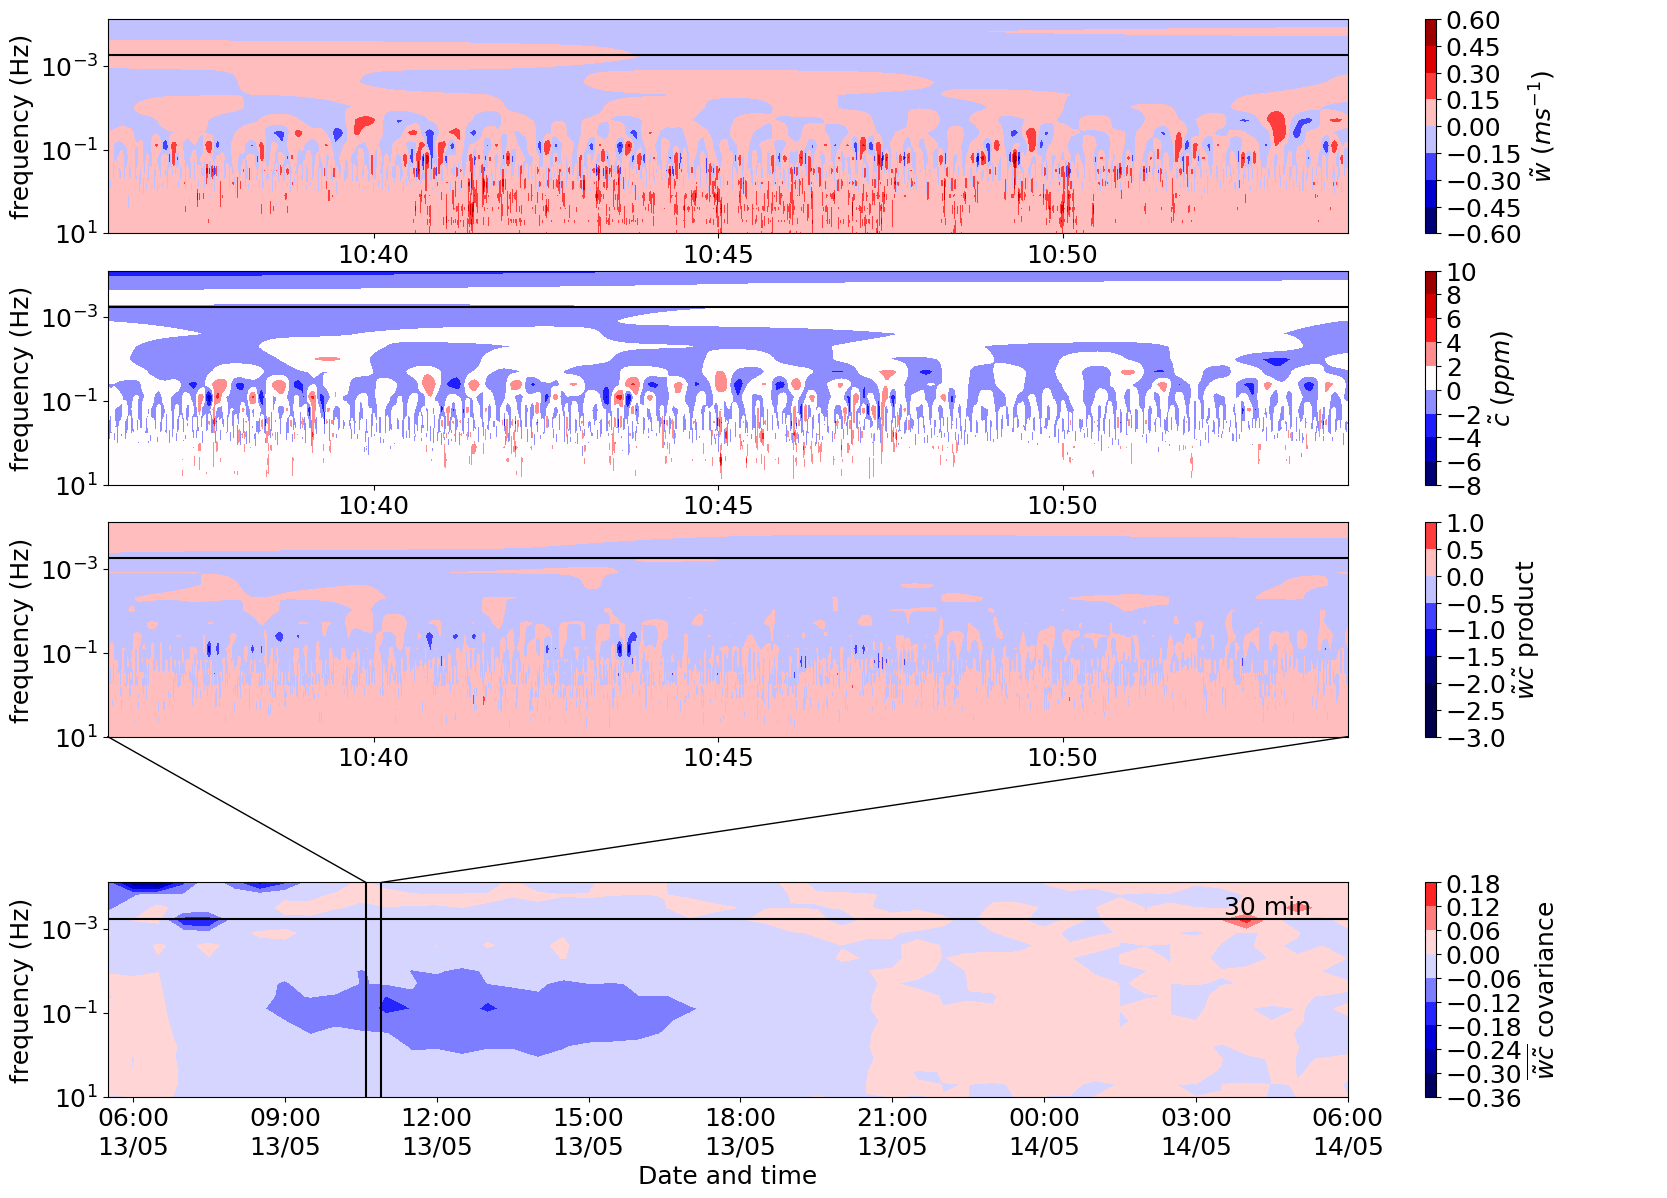

In [6]:
import os
if 'current_file_folder' not in globals(): current_file_folder = os.getcwd()
os.chdir(current_file_folder+'/../..')
from waveletec._core import wavelet_functions
from waveletec import _core as hc24
if 'current_file_folder' in globals(): os.chdir(current_file_folder)
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
plt.rcParams.update({'font.size': 18})

#thisraw_data = corrraw_data.interpolate().dropna(axis=1, how='all').dropna()
thisraw_data = corrraw_data.dropna(axis=1, how='all').dropna()

wl_w, j = wavelet_functions.universal_wt(thisraw_data.w.to_list(), 'dwt', wavelet='db6', fs=20, f0=1/(3*60*60), f1=10, fn=180, 
                 dj=1/12, inv=True)
wl_co2, _ = wavelet_functions.universal_wt(thisraw_data.co2.to_list(), 'dwt', wavelet='db6', fs=20, f0=1/(3*60*60), f1=10, fn=180, 
                 dj=1/12, inv=True)
fs = [1/hc24.j2sj(j_, 20) for j_ in j]
Xi, Yi = np.meshgrid(thisraw_data.TIMESTAMP_ns.values, fs)

plt.subplots(5,1, figsize=(20,14), gridspec_kw={'height_ratios': [3,3,3,1,3]})
i0 = 10.2
i1 = 10.8

plt.subplot(511)
plt.axhline(1/(60*60*.5), c='k')
plt.contourf(Xi[:-1, int(i0*36000):int(i1*36000)], Yi[:-1, int(i0*36000):int(i1*36000)], wl_w[:-1, int(i0*36000):int(i1*36000)], cmap=plt.cm.seismic)
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('frequency (Hz)')
plt.colorbar().set_label(r"$\~w$ ($ms^{-1}$)", rotation=90)

plt.subplot(512)
plt.axhline(1/(60*60*.5), c='k')
plt.contourf(Xi[:-1, int(i0*36000):int(i1*36000)], Yi[:-1, int(i0*36000):int(i1*36000)], wl_co2[:-1, int(i0*36000):int(i1*36000)], cmap=plt.cm.seismic)
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('frequency (Hz)')
plt.colorbar().set_label(r"$\~c$ ($ppm$)", rotation=90)

plt.subplot(513)
Zi = (wl_w * wl_co2)
plt.axhline(1/(60*60*.5), c='k')
plt.contourf(Xi[:-1, int(i0*36000):int(i1*36000)], Yi[:-1, int(i0*36000):int(i1*36000)], Zi[:-1, int(i0*36000):int(i1*36000)], 
             vmin=-2, vmax=2, cmap=plt.cm.seismic)
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('frequency (Hz)')
plt.colorbar().set_label(r"$\~w\~c$ product")
lastax = plt.gca()

plt.subplot(514)
plt.gca().axis('off')

plt.subplot(515)
Zj = pd.concat([thisraw_data['TIMESTAMP'], pd.DataFrame((wl_w * wl_co2).T)], axis=1).groupby('TIMESTAMP').agg(np.nanmean).values.T
Xj, Yj = np.meshgrid(thisraw_data.TIMESTAMP.unique(), fs)

plt.annotate('30 min', xy=(0.9,0.85), xycoords='axes fraction')
plt.axhline(1/(60*60*.5), c='k')
plt.axvline(min(Xi[0, int(i0*36000):int(i1*36000)]), c='k')
plt.axvline(max(Xi[0, int(i0*36000):int(i1*36000)]), c='k')
plt.contourf(Xj[:-1], Yj[:-1], Zj[:-1], vmin=-np.quantile(abs(Zi[:-1]), .99), vmax=np.quantile(abs(Zi[:-1]), .99), cmap=plt.cm.seismic)
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M\n%d/%m'))
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('frequency (Hz)')
plt.xlabel('Date and time')
plt.colorbar().set_label(r"$\overline{\~w\~c}$ covariance")
"""
plt.plot(thisraw_data.TIMESTAMP.unique(), np.nansum(Zj[:15], 0), c='k')
plt.xlim(min(thisraw_data.TIMESTAMP.unique()), max(thisraw_data.TIMESTAMP.unique()))
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M\n%d/%m'))
plt.xlabel('Date and time')
"""
from matplotlib.patches import ConnectionPatch
con = ConnectionPatch(xyA=(min(Xi[0, int(i0*36000):int(i1*36000)]),plt.gca().get_ylim()[1]), xyB=(0,0), coordsA="data", coordsB="axes fraction",
                      axesA=plt.gca(), axesB=lastax, color="k")
plt.gca().add_artist(con)
con = ConnectionPatch(xyA=(max(Xi[0, int(i0*36000):int(i1*36000)]),plt.gca().get_ylim()[1]), xyB=(1,0), coordsA="data", coordsB="axes fraction",
                      axesA=plt.gca(), axesB=lastax, color="k")
plt.gca().add_artist(con)

plt.show()


20Hz to 30min *(in time)*

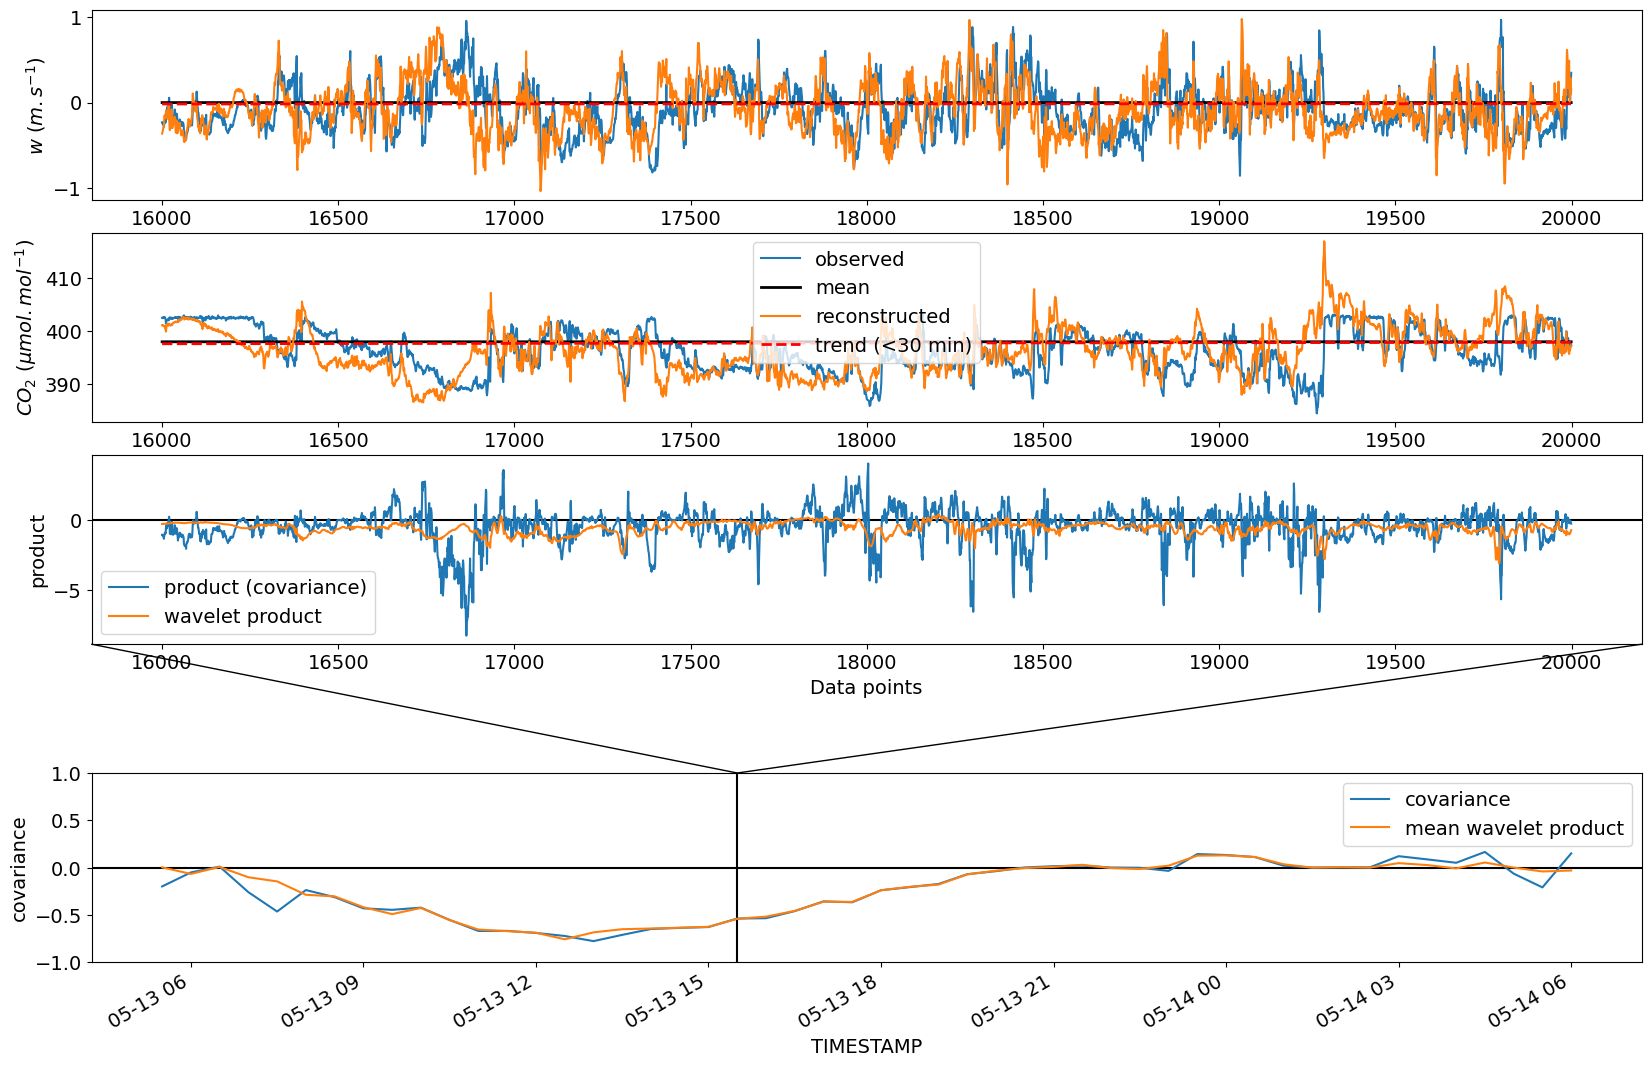

In [19]:
import os
if 'current_file_folder' not in globals(): current_file_folder = os.getcwd()
os.chdir(current_file_folder+'/../..')
from waveletec._core import wavelet_functions
from waveletec import _core as hc24
if 'current_file_folder' in globals(): os.chdir(current_file_folder)
from matplotlib import pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 14})

thisraw_dat0 = corrraw_data.interpolate().dropna(axis=1, how='all').dropna()
wl_signal, j = wavelet_functions.universal_wt(thisraw_dat0['co2'].to_list(), 'dwt', wavelet='db6', fs=20, f0=1/(.5*60*60), f1=10, fn=180, 
                 dj=1/12, inv=True)
wl_signalw, j = wavelet_functions.universal_wt(thisraw_dat0['w'].to_list(), 'dwt', wavelet='db6', fs=20, f0=1/(.5*60*60), f1=10, fn=180, 
                 dj=1/12, inv=True)
fs = [1/hc24.j2sj(j_, 20) for j_ in j]
f30 = len([j_ for j_ in j if j_<14.13575])

thisraw_dat0['wl_w'] = np.nansum(wl_signalw, 0)
thisraw_dat0['wl_co2'] = np.nansum(wl_signal, 0)
thisraw_dat0['wl_w_'] = np.nansum(wl_signalw[f30:], 0)
thisraw_dat0['wl_co2_'] = np.nansum(wl_signal[f30:], 0)
thisraw_dat0['wl_wco2'] = np.nansum((wl_signalw * wl_signal)[:f30], 0)

thisraw_data = thisraw_dat0.copy()
thisdate = "2022-05-13 15:30:00"
thisdate = pd.to_datetime(thisdate)
thisraw_data = thisraw_data.query(f'TIMESTAMP == "{thisdate}"')
thisraw_data = thisraw_data[16000 : 20000]
thisraw_data = thisraw_data.reset_index(drop=True)
thisraw_data.index += 16000

plt.subplots(5,1, figsize=(20,14), gridspec_kw={'height_ratios': [3,3,3,1,3]})

plt.subplot(511)
plt.plot(thisraw_data['w'], label='observed')
plt.plot(thisraw_data['w_'], label='mean', c='k', ls='-', lw=2)
plt.plot(thisraw_data['wl_w'], label='reconstructed')
plt.plot(thisraw_data['wl_w_'], label='trend (<30 min)', c='r', ls='--', lw=2)
plt.ylabel(r'$w$ ($m.s^{-1}$)')

plt.subplot(512)
plt.plot(thisraw_data['co2'], label='observed')
plt.plot(thisraw_data['co2_'], label='mean', c='k', ls='-', lw=2)
plt.plot(thisraw_data['wl_co2'], label='reconstructed')
plt.plot(thisraw_data['wl_co2_'], label='trend (<30 min)', c='r', ls='--', lw=2)
plt.ylabel(r'$CO_2$ ($μmol.mol^{-1}$)')
plt.legend()

plt.subplot(513)
plt.axhline(0, c='k')
plt.plot((thisraw_data['w'] - thisraw_data['w_']) *
         (thisraw_data['co2'] - thisraw_data['co2_']), label='product (covariance)')
plt.plot(thisraw_data['wl_wco2'], label='wavelet product')
plt.ylabel('product')
plt.xlabel('Data points')
plt.xlabel('Data points')
plt.legend()
lastax = plt.gca()

plt.subplot(514)
plt.gca().axis('off')

plt.subplot(515)
plt.axhline(0, c='k')
plt.axvline(thisdate, c='k')
# assuming density of dry air ~ 42 mol/m3 
thisraw_dat0.groupby('TIMESTAMP').apply(lambda row: pd.Series({'covariance': np.cov(row['w'], row['co2'])[0][1]})).reset_index(drop=False).plot(
    x='TIMESTAMP', ax=plt.gca(), label='covariance')
thisraw_dat0.groupby('TIMESTAMP')['wl_wco2'].agg(np.nanmean).reset_index(drop=False).rename(columns={'wl_wco2':'mean wavelet product'}).plot(
    x='TIMESTAMP', ax=plt.gca())
plt.ylabel('covariance')
plt.legend()
plt.ylim(-1, 1)

from matplotlib.patches import ConnectionPatch
con = ConnectionPatch(xyA=(thisdate,plt.gca().get_ylim()[1]), xyB=(0,0), coordsA="data", coordsB="axes fraction",
                      axesA=plt.gca(), axesB=lastax, color="k")
plt.gca().add_artist(con)
con = ConnectionPatch(xyA=(thisdate,plt.gca().get_ylim()[1]), xyB=(1,0), coordsA="data", coordsB="axes fraction",
                      axesA=plt.gca(), axesB=lastax, color="k")
plt.gca().add_artist(con)

plt.show()


CO2-H2O similarity

In [35]:
import os
if 'current_file_folder' not in globals(): current_file_folder = os.getcwd()
os.chdir(current_file_folder+'/../..')
from waveletec._core import wavelet_functions
from waveletec import _core as hc24
if 'current_file_folder' in globals(): os.chdir(current_file_folder)
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib
import numpy as np
plt.rcParams.update({'font.size': 18})

thisraw_data = corrraw_data.interpolate().dropna(axis=1, how='all').dropna()

wl_w, j = wavelet_functions.universal_wt(thisraw_data.w.to_list(), 'dwt', wavelet='db6', fs=20, f0=1/(3*60*60), f1=10, fn=180, 
                 dj=1/12, inv=True)
wl_co2, _ = wavelet_functions.universal_wt(thisraw_data.co2.to_list(), 'dwt', wavelet='db6', fs=20, f0=1/(3*60*60), f1=10, fn=180, 
                 dj=1/12, inv=True)
wl_h2o, _ = wavelet_functions.universal_wt(thisraw_data.h2o.to_list(), 'dwt', wavelet='db6', fs=20, f0=1/(3*60*60), f1=10, fn=180, 
                 dj=1/12, inv=True)
fs = [1/hc24.j2sj(j_, 20) for j_ in j]
Xi, Yi = np.meshgrid(thisraw_data.TIMESTAMP_ns.values, fs)

plt.subplots(7,1, figsize=(12,16), gridspec_kw={'height_ratios': [3,3,1,3,3,3,3]})
i0 = 10
i1 = 11
cM = 2
pM = .95
norm = None # .SymLogNorm(.5) .PowerNorm(2) .LogNorm(1, 2)#

plt.subplot(711)
plt.axhline(1/(60*60*.5), c='k', lw=1, ls='--')
plt.contourf(Xi[:-1, int(i0*36000):int(i1*36000)], Yi[:-1, int(i0*36000):int(i1*36000)], 
             (wl_w*wl_h2o)[:-1, int(i0*36000):int(i1*36000)], cmap=plt.cm.seismic, vmin=-.3, vmax=.3)
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('frequency (Hz)')
plt.xticks([])
plt.xlabel('')
plt.colorbar().set_label(r"$\~w\~H_2O$", rotation=90)

plt.subplot(712)
plt.axhline(1/(60*60*.5), c='k', lw=1, ls='--')
plt.contourf(Xi[:-1, int(i0*36000):int(i1*36000)], Yi[:-1, int(i0*36000):int(i1*36000)], 
             (wl_w*wl_co2)[:-1, int(i0*36000):int(i1*36000)], cmap=plt.cm.seismic, vmin=-3, vmax=3)
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('')
plt.colorbar().set_label(r"$\~w\~CO_2$", rotation=90)
lastax = plt.gca()

plt.subplot(713)
plt.gca().axis('off')

plt.subplot(714)
# assuming density of dry air ~ 42 mol/m3 
Zj = pd.concat([thisraw_data['TIMESTAMP'], 42 * pd.DataFrame(np.where(((wl_w * wl_co2)<0) * ((wl_w * wl_h2o)>0), wl_w * wl_co2, 0).T)], axis=1).groupby('TIMESTAMP').agg(np.nanmean).values.T
Xj, Yj = np.meshgrid(thisraw_data.TIMESTAMP.unique(), fs)

plt.annotate('30 min', xy=(0.88,0.85), xycoords='axes fraction')
plt.axhline(1/(60*60*.5), c='k', lw=1, ls='--')
plt.axvline(min(Xi[0, int(i0*36000):int(i1*36000)]), c='k')
plt.axvline(max(Xi[0, int(i0*36000):int(i1*36000)]), c='k')
levels = np.linspace(-np.quantile(abs(Zj[:14]), pM) * cM, 0, 10).round(2)
plt.contourf(Xj[:-1], Yj[:-1], Zj[:-1], vmin=min(levels), vmax=max(levels), cmap=plt.cm.Blues_r, norm=norm, levels=levels, extend='min')
#plt.contourf(Xj[:-1], Yj[:-1], Zj[:-1], vmin=-np.quantile(abs(Zj[:14]), .99) * cM, vmax=np.quantile(abs(Zj[:14]), .99) * cM, cmap=plt.cm.seismic, norm=norm)
plt.xticks([])
plt.xlabel('')
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('')
plt.colorbar().set_label(r"$ρ\overline{\~w\~{CO}_2}$"+"\n"+r"($μmol.m^{-2}.s^{-1}$)"+"\n"+r"$ρ=42mol.m^{-3}$")

from matplotlib.patches import ConnectionPatch
con = ConnectionPatch(xyA=(min(Xi[0, int(i0*36000):int(i1*36000)]),plt.gca().get_ylim()[1]), xyB=(0,0), coordsA="data", coordsB="axes fraction",
                      axesA=plt.gca(), axesB=lastax, color="k")
plt.gca().add_artist(con)
con = ConnectionPatch(xyA=(max(Xi[0, int(i0*36000):int(i1*36000)]),plt.gca().get_ylim()[1]), xyB=(1,0), coordsA="data", coordsB="axes fraction",
                      axesA=plt.gca(), axesB=lastax, color="k")
plt.gca().add_artist(con)

plt.subplot(715)
plt.axhline(1/(60*60*.5), c='k', lw=1, ls='--')
plt.axvline(min(Xi[0, int(i0*36000):int(i1*36000)]), c='k')
plt.axvline(max(Xi[0, int(i0*36000):int(i1*36000)]), c='k')
Zj = pd.concat([thisraw_data['TIMESTAMP'], 42 * pd.DataFrame(np.where(((wl_w * wl_co2)>0) * ((wl_w * wl_h2o)>0), wl_w * wl_co2, 0).T)], axis=1).groupby('TIMESTAMP').agg(np.nanmean).values.T
levels = np.linspace(0, np.quantile(abs(Zj[:14]), pM) * cM, 10).round(2)
plt.contourf(Xj[:-1], Yj[:-1], Zj[:-1], vmin=min(levels), vmax=max(levels), cmap=plt.cm.Reds, norm=norm, levels=levels, extend='max')
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('')
plt.colorbar().set_label(r"$ρ\overline{\~w\~{CO}_2}$")
plt.xticks([])
plt.xlabel('')

plt.subplot(716)
plt.axhline(1/(60*60*.5), c='k', lw=1, ls='--')
plt.axvline(min(Xi[0, int(i0*36000):int(i1*36000)]), c='k')
plt.axvline(max(Xi[0, int(i0*36000):int(i1*36000)]), c='k')
Zj = pd.concat([thisraw_data['TIMESTAMP'], 42 * pd.DataFrame(np.where(((wl_w * wl_co2)>0) * ((wl_w * wl_h2o)<0), wl_w * wl_co2, 0).T)], axis=1).groupby('TIMESTAMP').agg(np.nanmean).values.T
levels = np.linspace(0, np.quantile(abs(Zj[:14]), pM) * cM, 10).round(2)
plt.contourf(Xj[:-1], Yj[:-1], Zj[:-1], vmin=min(levels), vmax=max(levels), cmap=plt.cm.Reds, norm=norm, levels=levels, extend='max')
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('')
plt.colorbar().set_label(r"$ρ\overline{\~w\~{CO}_2}$")
plt.xticks([])
plt.xlabel('')

plt.subplot(717)
plt.axhline(1/(60*60*.5), c='k', lw=1, ls='--')
plt.axvline(min(Xi[0, int(i0*36000):int(i1*36000)]), c='k')
plt.axvline(max(Xi[0, int(i0*36000):int(i1*36000)]), c='k')
Zj = pd.concat([thisraw_data['TIMESTAMP'], 42 * pd.DataFrame(np.where(((wl_w * wl_co2)<0) * ((wl_w * wl_h2o)<0), wl_w * wl_co2, 0).T)], axis=1).groupby('TIMESTAMP').agg(np.nanmean).values.T
levels = np.linspace(-np.quantile(abs(Zj[:14]), pM) * cM, 0, 10).round(2)
plt.contourf(Xj[:-1], Yj[:-1], Zj[:-1], vmin=min(levels), vmax=max(levels), cmap=plt.cm.Blues_r, norm=norm, levels=levels, extend='min')
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M\n%d/%m'))
plt.xlabel('Date and time')
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('')
plt.colorbar().set_label(r"$ρ\overline{\~w\~{CO}_2}$")

plt.show()


Fluxes

In [66]:
"""Make one unified dataset"""
import pandas as pd
import re

fluxnet_data = pd.read_csv('output/eddypro_FR-Gri_sample_fluxnet_2024-04-24T111754_adv.csv')
fluxnet_data['TIMESTAMP'] = pd.to_datetime(fluxnet_data['TIMESTAMP_START'], format='%Y%m%d%H%M')
wavelet_data = pd.read_csv('output/wavelet_flux/FR-Gri_sample_CDWT_full_cospectra.csv')
wavelet_data['TIMESTAMP'] = pd.to_datetime(wavelet_data['TIMESTAMP'])
partitd_data = pd.read_csv('output/wavelet_flux/FR-Gri_sample_CDWT_partitioning_H2O.30mn.csv')
partitd_data['TIMESTAMP'] = pd.to_datetime(partitd_data['TIMESTAMP'])

# Load data and compute datetime hours
all_flux_data = fluxnet_data.copy()
all_flux_data = pd.merge(all_flux_data, wavelet_data, on='TIMESTAMP', how='inner', suffixes=('', '_WL'))
all_flux_data = pd.merge(all_flux_data, partitd_data, on='TIMESTAMP', how='inner', suffixes=('', '_PT'))
all_flux_data['HH'] = (all_flux_data['TIMESTAMP'] - all_flux_data['TIMESTAMP'].dt.floor('1D')) / pd.Timedelta('1h')
all_flux_data['MM'] = all_flux_data.TIMESTAMP.dt.month.astype(str) + '/' + all_flux_data.TIMESTAMP.dt.year.astype(str)

# Convert covariance to flux
wavelet_plus = []
for c in set(all_flux_data.columns) - set(fluxnet_data.columns):
    if re.findall('_[0-9]+$', c) or c.endswith('qc'): continue
    # depends of the unit (h2o changes from run to run)
    if c[:3] in ['wco', 'wch', 'wn2']:
        gas_correction = (1 / all_flux_data.DRYAIR_MV)
        wavelet_plus += [pd.DataFrame({'F_UNCORR_'+c: all_flux_data[c] * gas_correction})]
        wavelet_plus   += [pd.DataFrame({'F_'+c:      all_flux_data[c]  * gas_correction * all_flux_data[f'FC_SCF']})]
    elif c[:3] in ['wts']:
        heat_correction = all_flux_data.AIR_DENSITY * all_flux_data.AIR_CP
        wavelet_plus += [pd.DataFrame({'F_UNCORR_'+c: all_flux_data[c] * heat_correction})]
        wavelet_plus += [pd.DataFrame({'F_'+c:        all_flux_data[c] * heat_correction * all_flux_data[f'H_SCF']})]
    elif c[:4] in ['wh2o']:
        water_correction = 10**-3 * (10**3 * (3147.5 - 2.37 * all_flux_data.TA_EP)) * 0.01802 / all_flux_data.DRYAIR_MV
        wavelet_plus += [pd.DataFrame({'F_UNCORR_'+c: all_flux_data[c] * water_correction})]
        wavelet_plus += [pd.DataFrame({'F_'+c:        all_flux_data[c] * water_correction * all_flux_data[f'LE_SCF']})]
    elif c[:3] in ['NEE', 'GPP', 'Rec']:
        gas_correction = (1 / all_flux_data.DRYAIR_MV)
        wavelet_plus += [pd.DataFrame({'F_UNCORR_'+c: all_flux_data[c] * gas_correction})]
        wavelet_plus   += [pd.DataFrame({'F_'+c:      all_flux_data[c]  * gas_correction * all_flux_data[f'FC_SCF']})]

# Concatenate converted columns to main data
all_flux_data = all_flux_data = pd.concat([all_flux_data] + wavelet_plus, axis=1).copy()


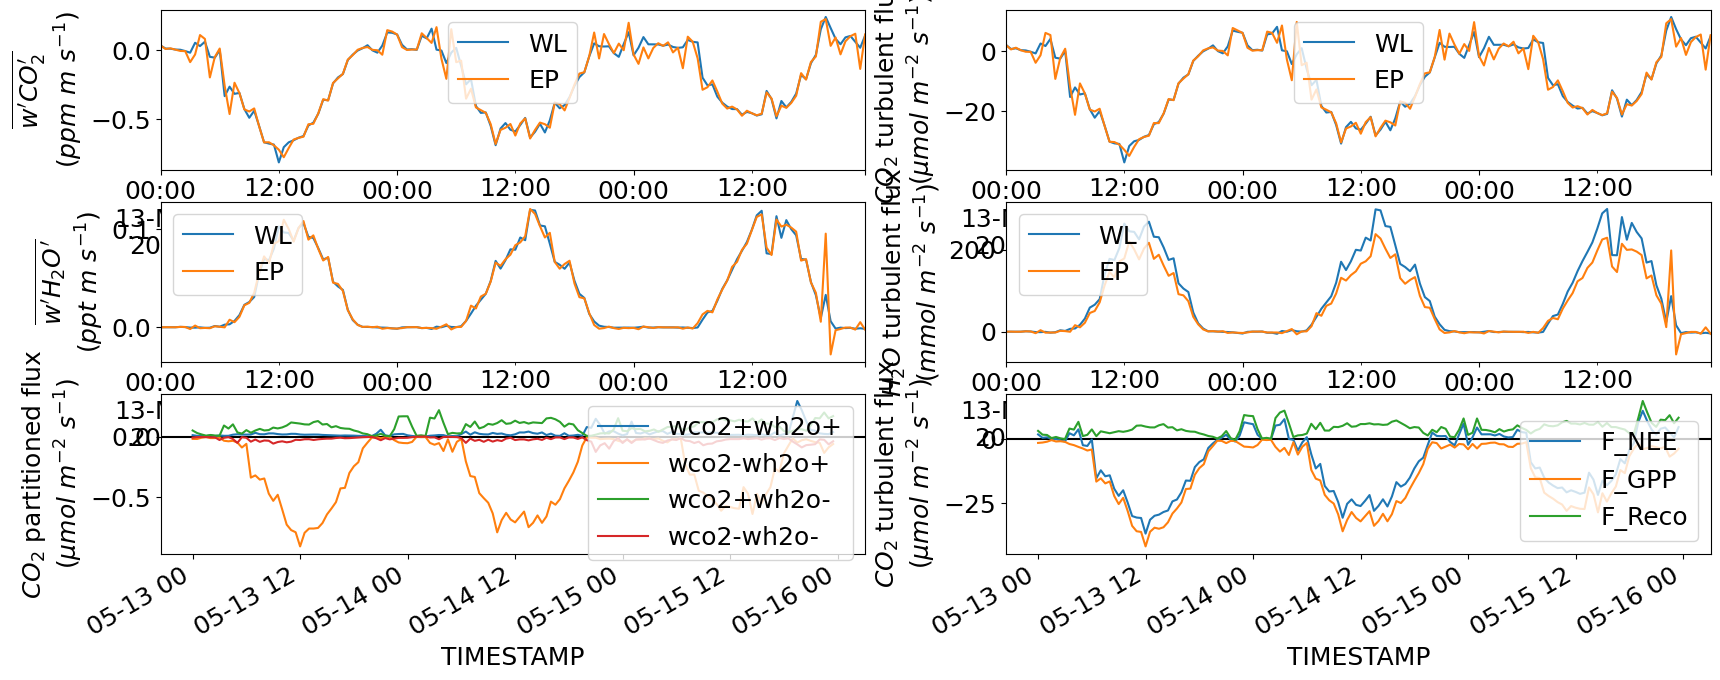

In [68]:
from matplotlib import pyplot as plt

plt.figure(1, figsize=(20,8))

plt.subplot(321)
all_flux_data[['TIMESTAMP', 'wco2', 'W_CO2_MEAS_COV']].rename(columns={'wco2': 'WL', 'W_CO2_MEAS_COV': 'EP'}).plot(x='TIMESTAMP', ylabel=r"$\overline{w'CO_2'}$" +"\n"+ r"($ppm\ m\ s^{-1}$)", ax=plt.gca())
plt.subplot(322)
all_flux_data[['TIMESTAMP', 'F_wco2', 'FC']].rename(columns={'F_wco2': 'WL', 'FC': 'EP'}).plot(x='TIMESTAMP', ylabel=r'$CO_2$ turbulent flux' +'\n'+ r'($μmol\ m^{-2}\ s^{-1}$)', ax=plt.gca())

plt.subplot(323)
all_flux_data[['TIMESTAMP', 'wh2o', 'W_H2O_MEAS_COV']].rename(columns={'wh2o': 'WL', 'W_H2O_MEAS_COV': 'EP'}).plot(x='TIMESTAMP', ylabel=r"$\overline{w'H_2O'}$" +"\n"+ r"($ppt\ m\ s^{-1}$)", ax=plt.gca())
plt.subplot(324)
all_flux_data[['TIMESTAMP', 'F_wh2o', 'LE']].rename(columns={'F_wh2o': 'WL', 'LE': 'EP'}).plot(x='TIMESTAMP', ylabel=r'$H_2O$ turbulent flux' +'\n'+ r'($mmol\ m^{-2}\ s^{-1}$)', ax=plt.gca())

plt.subplot(325)
plt.axhline(0, c='k')
all_flux_data[['TIMESTAMP', 'wco2+wh2o+', 'wco2-wh2o+', 'wco2+wh2o-', 'wco2-wh2o-']].plot(x='TIMESTAMP', ylabel=r'$CO_2$ partitioned flux' +'\n'+ r'($μmol\ m^{-2}\ s^{-1}$)', ax=plt.gca())
plt.subplot(326)
plt.axhline(0, c='k')
all_flux_data[['TIMESTAMP', 'F_NEE', 'F_GPP', 'F_Reco']].plot(x='TIMESTAMP', ylabel=r'$CO_2$ turbulent flux' +'\n'+ r'($μmol\ m^{-2}\ s^{-1}$)', ax=plt.gca())
plt.show()


# End